In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import ee
ee.Authenticate()
ee.Initialize(project='arcticecosystems')

In [14]:
df = pd.read_csv("../arctic-ecosystems/data/FLX_SE-St1_FLUXNET2015_FULLSET_HH_2012-2019_beta-3/FLX_SE-St1_FLUXNET2015_FULLSET_HH_2012-2019_beta-3.csv")

In [ ]:
df[""]

In [3]:
flux_vars = [
    #"TIMESTAMP_START", # ISO Timestamp (YYYYMMDDHHMM)
    "TIMESTAMP_END",
    
    # Atmospheric Variables
    #"PA", # Atmospheric Pressure (kPa)
    #"PA_ERA", # ERA
    "PA_F", # Gap filled
    #"PA_F_QC" # Quality flag
    #"RH", # Relative Humidity (%)
    "TA_F", # Gap-filled air temperature. Real measurements gap-filled with probably a modelled temperature
    #"TA_F_QC", # Quality flag for TA_F. 1 is good, 3 is bad quality.
    #"TA_ERA", # ERA Reanalyses Temperature
    "VPD_F", # Gap-filled Vapour pressure deficit (hPa)
    #"VPD_F_QC", # Quality flag for vapour pressure
    #"WS", # Wind speed (m s-1)
    "WS_F", # gapfilled wind speed (m s-1)
    
    # Precipitation Meteorological Variables
    #"P", # Precipitation (mm)
    #"P_ERA",, # Precipitation (mm) downscaled from ERA, linear regressed using site data
    "P_F", # Gap-filled precipitation (mm)
    #"P_F_QC", # Quality Flag
    
    # Radiation Meteorological Variables
    "LW_IN_F", # Longwave radiation downwelling (W m-2) gap-filled with ERA and MDS (marginal distribution sampling)
    #"LW_IN_F_MDS", # as above, but only gap filled by MDS, no ERA.
    #"LW_IN_JSB", # 	Longwave radiation, incoming, calculated from TA_F_MDS, SW_IN_F_MDS, VPD_F_MDS and SW_IN_POT using the JSBACH algorithm (Sonke Zaehle);
    #"LW_IN_JSB_F", # as above but gap filled using the JSBACH algorithm (Sonke Zaehle)
    "SW_IN_F", # Shortwave radiation downwelling (W m-2) gap-filled with ERA and MDS (marginal distribution sampling)
    
    
    # Ecosystem
    # DT = Daytime
    # NT = Nighttime
    # ustar? = the amount threshold of friction mixing. If mixing drops e.g. at night then we need to clean the data but at what threshold...
    # CUT = fixed through time critical ustar threshold
    # VUT = variable through time ustar threshold
    # mean = mean
    # SE = standard error
    # REF = reference selected baed on model efficiency
    "GPP_DT_VUT_REF", # GPP ref being the recommended variable for analysis. This is what ICOS preview uses.
    #"GPP_DT_VUT_SE",
    #"NEE_VUT_REF", # Net ecosystem exchange (µmolCO2 m-2 s-1)
    #"NEE_VUT_SE",
    #"RECO_DT_VUT_REF", # Ecosystem respiration (µmolCO2 m-2 s-1)
    #"RECO_DT_VUT_SE",
    
    "H_F_MDS", # sensible heat flux (W m-2)
    "LE_F_MDS" # Latent Het flux (W m-2)
    
    ]

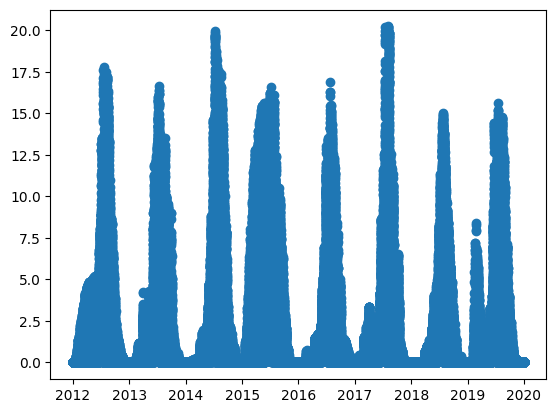

In [4]:
plt.scatter(x = pd.to_datetime(flux_df[flux_vars]["TIMESTAMP_END"], format="%Y%m%d%H%M"), y = flux_df[flux_vars]["GPP_DT_VUT_REF"])

In [ ]:
temp = flux_df[flux_vars][flux_df[flux_vars]["RH"] > -9999]
plt.scatter(x = pd.to_datetime(temp[flux_vars]["TIMESTAMP_END"], format="%Y%m%d%H%M"), y = temp[flux_vars]["RH"])

In [5]:
# Convert timestamp to datetime
df['datetime'] = pd.to_datetime(df['TIMESTAMP_START'], format='%Y%m%d%H%M')
df2 = df[["datetime", "GPP_DT_VUT_REF"]]
df2['lat'] = 68.35415
df2['lon'] = 19.050333

C:\Users\Laurie\AppData\Local\Temp\ipykernel_23180\1076066062.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['lat'] = 68.35415
C:\Users\Laurie\AppData\Local\Temp\ipykernel_23180\1076066062.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['lon'] = 19.050333


In [9]:
def df_to_fc(df):
    features = []
    for _, row in df.iterrows():
        point = ee.Geometry.Point([row['lon'], row['lat']])
        props = row.drop(['lat', 'lon']).to_dict()
        props['datetime'] = row['datetime'].strftime('%Y-%m-%dT%H:%M:%S')  # Earth Engine ISO format
        feature = ee.Feature(point, props)
        features.append(feature)
    return ee.FeatureCollection(features)

flux_fc = df_to_fc(df2)

In [13]:
# upload as asset instead?
df2.to_csv("flux_data_export.csv", index=False)
flux_fc = ee.FeatureCollection('users/lauriequincey/flux_data_export')

Convert Flux CSV to ee.FeatureCollection

In [4]:
def df_to_fc(df, lon=19.050333, lat=68.35415):
    features = []

    for _, row in df.iterrows():
        point = ee.Geometry.Point([lon, lat])

        # Convert row to dictionary
        props = row.to_dict()

        # Add system:time_start if there's a 'date' field
        if 'date' in props:
            props['system:time_start'] = ee.Date(props['date']).millis()

        features.append(ee.Feature(point, props))

    return ee.FeatureCollection(features)

# Usage
flux_fc = df_to_fc(df2)

In [19]:
print(flux_fc.first().getInfo())

: 

Prepare Landsat Collection with NDVI

In [6]:
def add_ndvi(image):

    ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

landsat = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
            .filterBounds(ee.Geometry.Point([19.050333, 68.35415]))
            .filterDate('2018-05-01', '2018-06-01')
            .map(add_ndvi)
            .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI']))

In [7]:
print('Image Collection Size:', landsat.size().getInfo())

Image Collection Size: 4


Match Each Flux Record to Closest Landsat Image

In [8]:
def match_flux_with_image(feature):
    time = ee.Date(feature.get('system:time_start'))
    
    def set_diff(img):
        return img.set('diff', ee.Number(img.get('system:time_start')).subtract(time.millis()).abs())

    # Find the closest image by date
    closest = landsat.map(set_diff).sort('diff').first()

    # Sample pixel at the feature location
    #sampled = closest.sample(
    #    region=feature.geometry(),
    #    scale=30,
    #    numPixels=1,
    #    geometries=True
    #).first()

    # Add the GPP value to the sampled feature
    return ee.Feature(time)#sampled.set('GPP', feature.get('GPP'))

# Apply to all features in your flux FeatureCollection
training_fc = flux_fc.map(match_flux_with_image)

In [ ]:
def match_flux_with_image(feature):
    time = ee.Date(feature.get('system:time_start'))

    return ee.Feature(feature.geometry(), {
        'flux_time': time.format('YYYY-MM-dd')
    })
# Apply to all features in your flux FeatureCollection
training_fc = flux_fc.map(match_flux_with_image)

In [9]:
print('Image Collection Size:', training_fc.size().getInfo())

: 

Train Random Forest Regressor

https://gis.stackexchange.com/questions/316739/difference-between-gee-and-sklearn-random-forest-output

In [ ]:
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI']

classifier = ee.Classifier.smileRandomForest(50).train(
    features=training_fc,
    classProperty='GPP',
    inputProperties=bands
)

Apply the Model to an Image

In [ ]:
first_image = landsat.first()
predicted = first_image.classify(classifier).rename('Predicted_GPP')